## **Part b)**

In [ ]:
from scipy.stats import norm
import numpy as np
from numpy import count_nonzero,expand_dims,linspace,tile

def rouwenhorst_ar1(mu, gamma, sigma, N):
    """
    This function discretizes an AR(1) process using Rouwenhorst’s method.
            y(t) = mu + gamma*y(t-1) + eps(t), eps(t) ~ NID(0,sigma^2)

    Input:
        mu    : Intercept of AR(1).
        gamma   : Persistence of AR(1).
        sigma : Standard deviation of error term.
        N     : Number of states.

    Output:
        y    : Grid for the AR(1) process.
        pmat : Transition probability matrix.
    """

    #%% Construct equally spaced grid using Rouwenhorst’s method.
    ar_mean = mu/(1 - gamma)  # The mean of a stationary AR(1) process is mu/(1 - rho)
    ar_sd = sigma*(np.sqrt((N - 1)/(1 - gamma**2))) # The std. dev of a stationary AR(1) process is sigma/sqrt(1-rho^2)

    # Rouwenhorst's standard deviation for the grid spacing
    y1 = ar_mean - ar_sd
    yn = ar_mean + ar_sd

    # Create the grid with N equally spaced points
    y = linspace(y1,yn,N,endpoint=True) # Equally spaced grid. Include endpoint (endpoint=True) and record stepsize, d (retstep=True).

    #%% Construct the transition probability matrix for the process.
    # Transition matrix for N = 2
    p = (1 - gamma)/2
    pmat_2 = np.array([[p, 1 - p],
                       [1 - p, p]])

    if N == 2:
        return y, pmat_2
    else:
        for n in range(3, N + 1):
            p_old = pmat_2
            # Recursive transition matrix construction for N > 2
            pmat_N = p * np.block([[p_old, np.zeros((p_old.shape[0], 1))],
                                   [np.zeros((1, p_old.shape[1] + 1))]]) \
                   + (1 - p) * np.block([[np.zeros((p_old.shape[0], 1)), p_old],
                                         [np.zeros((1, p_old.shape[1] + 1))]]) \
                   + (1 - p) * np.block([[np.zeros((1, p_old.shape[1] + 1))],
                                         [p_old, np.zeros((p_old.shape[0], 1))]]) \
                   + p * np.block([[np.zeros((1, p_old.shape[1] + 1))],
                                   [np.zeros((p_old.shape[0], 1)), p_old]])

            # Normalize rows (divide all rows except the first and the last by 2 to account for double counting, so the probabilities sum to one)
            pmat_N[1:-1, :] /= 2

            # Update for next iteration
            pmat_2 = pmat_N

    #%% Output
    y = expand_dims(y, axis=0) # Convert 0-dimensional array to a row vector.

    if count_nonzero(pmat_2.sum(axis = 1) < 0.999) > 0:
        raise Exception("Some columns of transition matrix don't sum to 1.")

    return y,pmat_2

In [ ]:
mu = 0.50000 # Intercept.
gamma = 0.85000 # Persistence.
sigma = 1.00000 # Std. dev. of error term.
N = 7 # Number of states.

rouwenhorst_ar1(mu, gamma, sigma, N)

(array([[-1.3166,  0.2334,  1.7834,  3.3333,  4.8833,  6.4333,  7.9832]]),
 array([[0.    , 0.    , 0.0004, 0.0067, 0.0618, 0.3047, 0.6264],
        [0.    , 0.0001, 0.0033, 0.0415, 0.2573, 0.647 , 0.0508],
        [0.    , 0.0013, 0.0249, 0.2072, 0.6595, 0.1029, 0.0041],
        [0.0003, 0.0124, 0.1554, 0.6637, 0.1554, 0.0124, 0.0003],
        [0.0041, 0.1029, 0.6595, 0.2072, 0.0249, 0.0013, 0.    ],
        [0.0508, 0.647 , 0.2573, 0.0415, 0.0033, 0.0001, 0.    ],
        [0.6264, 0.3047, 0.0618, 0.0067, 0.0004, 0.    , 0.    ]]))

## **Part c) & d)**

In [ ]:
"""

simulate.py
------------

This code simulates a Markov chain given a grid and transition matrix.

"""

#%% Imports.

from numpy import cumsum,linspace,nonzero,ones,zeros
from numpy.random import uniform

#%% Simulation function.

def simulate(grid,pmat,T):
    """

    This code simulates a Markov chain given a grid of points from the discretized process and the associated transition matrix.

    Input:
        grid : K x N Grid of discretized points.
        pmat : Transition probability matrix.
        seed : Set seed for rng.
        T    : Number of periods to simulate.

    Output:
        y : Simulated series.

    """

    #%% Initialize.

    N = grid.shape[1] # Number of states.
    pi0 = cumsum(ones(N)/N) # CDF of uniform distribution for initial state.
    init = linspace(0, N-1, N, endpoint = True) # State indices.
    state0 = int(init[uniform() <= pi0][0]) # Initial state.

    #%% Simulate.

    cmat = cumsum(pmat, axis=1) # CDF matrix.
    y = zeros((grid.shape[0], T*2)) # Container

    for i in range(0, T*2): # Simulation.
        y[:, i] = grid[:, state0] # Current state.
        state1 = cmat[state0, uniform() <= cmat[state0, :]] # State next period.
        state0 = nonzero(cmat[state0, :] == state1[0])[0][0] # Update index for next period.

    y = y[:, T:T*2] # Burn the first half.

    #%% Output.

    return y

## **Part c)**

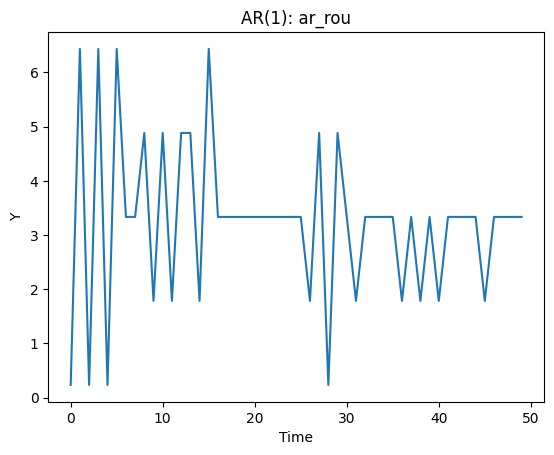

In [ ]:
"""

run_rou.py
--------------

This code discretizes a Markov Chain using Rouwenhorst's Method and simulates it.

"""

#%% Imports.

import matplotlib.pyplot as plt
import numpy as np

#%% Discretize AR(1).

mu = 0.50000 # Intercept.
gamma = 0.85000 # Persistence.
sigma = 1.00000 # Std. dev. of error term.
N = 7 # Number of states.

ar = {'rou': rouwenhorst_ar1} # Method.
ar_y = {} # Container.
ar_pi = {} # Container.

ar_y['rou'], ar_pi['rou'] = ar['rou'](mu, gamma, sigma, N)

del mu, gamma, sigma, N

#%% Simulate the AR(1)'s based on discretized processes.

seed = 2025 # Seed for random number.
T = 50 # Time horizon.

sim = {}

# Simulate the Markov Chain.
for i in ar_y.keys():
    np.random.seed(seed)
    sim["ar_" + i] = simulate(ar_y[i], ar_pi[i], T)

del seed

#%% Plot the time series.

time = range(0, T) # X-axis.

# Plot.
for i in sim:
    plt.figure()
    plt.plot(time,np.squeeze(sim[i]))
    plt.xlabel('Time')
    plt.ylabel('Y')
    plt.title("AR(1): " + i)
    plt.show()

del i

#%% Re-estimate the AR(1) series using simulated data.

big1 = np.ones((T-1, 1)) # Intercept.
bhat = {} # Container.

# Estimate the coefficents using the simulated Markov Chain.
for i in sim:
    y = np.expand_dims(sim[i][0, 1:T],axis = 1)
    x  = np.expand_dims(sim[i][0, 0:T-1], axis = 1)
    bigX = np.concatenate((big1, x), axis = 1)
    bhat[i] = np.linalg.inv(bigX.T@bigX)@bigX.T@y

del i, T, ar, x, y, big1, bigX

## **Part d)**

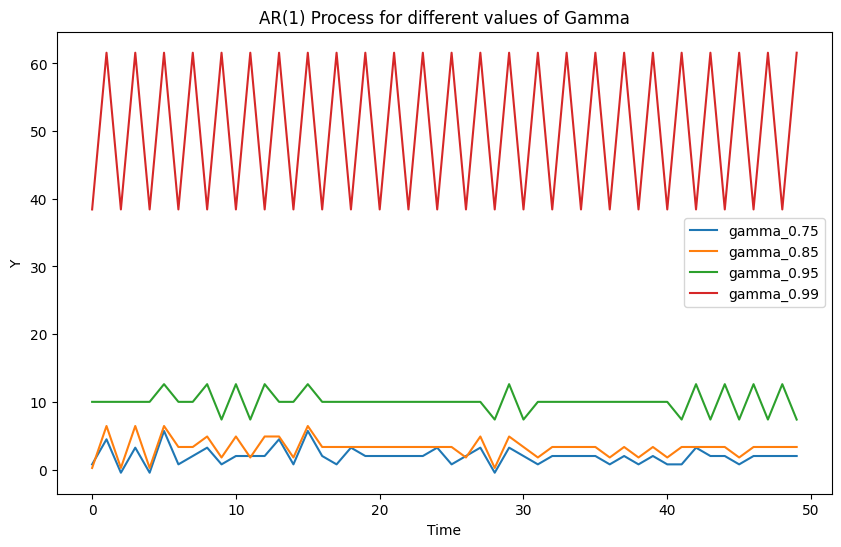

In [ ]:
"""

run_rou_multiple.py
--------------

This code discretizes a Markov Chain using Rouwenhorst's Method and simulates it with different values of gamma.

"""

#%% Imports.
import matplotlib.pyplot as plt
import numpy as np

#from tauchen import tauchen_ar1
#from simulate import simulate

#%% Discretize AR(1) for different values of gamma.

mu = 0.50000  # Intercept.
gamma_list = [0.75000, 0.85000, 0.95000,0.99000]  # Different values of persistence (gamma).
sigma = 1.00000  # Std. dev. of error term.
N = 7  # Number of states.

ar = {} # Method container.
ar_y = {} # Container for state values.
ar_pi = {} # Container for transition probabilities.

for gamma_i in gamma_list:
    key = f'gamma_{gamma_i}'
    ar[key] = rouwenhorst_ar1
    ar_y[key], ar_pi[key] = ar[key](mu, gamma_i, sigma, N)

#%% Simulate the AR(1) processes based on discretized values.

seed = 2025  # Seed for reproducibility.
T = 50  # Time horizon.

sim = {}

# Simulate the Markov Chains for each gamma value.
for key in ar_y.keys():
    np.random.seed(seed)
    sim[key] = simulate(ar_y[key], ar_pi[key], T)

#%% Plot all time series in one graph for comparison.

plt.figure(figsize=(10, 6))

for key in sim:
    plt.plot(range(T), np.squeeze(sim[key]), label=key)

plt.xlabel('Time')
plt.ylabel('Y')
plt.title('AR(1) Process for different values of Gamma')
plt.legend()
plt.show()

#%% Re-estimate the AR(1) series using simulated data.

big1 = np.ones((T-1, 1))  # Intercept.
bhat = {}  # Container.

# Estimate the coefficients using the simulated Markov Chain.
for key in sim:
    y = np.expand_dims(sim[key][0, 1:T], axis=1)
    x = np.expand_dims(sim[key][0, 0:T-1], axis=1)
    bigX = np.concatenate((big1, x), axis=1)
    bhat[key] = np.linalg.inv(bigX.T @ bigX) @ bigX.T @ y

del key, T, ar, x, y, big1, bigX